# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.shape)
print(feat_info.shape)

(891221, 85)
(85, 4)


In [4]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
print(feat_info.head())

              attribute information_level         type missing_or_unknown
0              AGER_TYP            person  categorical             [-1,0]
1  ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2             ANREDE_KZ            person  categorical             [-1,0]
3         CJT_GESAMTTYP            person  categorical                [0]
4     FINANZ_MINIMALIST            person      ordinal               [-1]


In [6]:
# to check the data type and if null(missing) values are present or not(naturally).
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [7]:
null_list = azdias.isnull().any()
print(null_list)

AGER_TYP                 False
ALTERSKATEGORIE_GROB     False
ANREDE_KZ                False
CJT_GESAMTTYP             True
FINANZ_MINIMALIST        False
FINANZ_SPARER            False
FINANZ_VORSORGER         False
FINANZ_ANLEGER           False
FINANZ_UNAUFFAELLIGER    False
FINANZ_HAUSBAUER         False
FINANZTYP                False
GEBURTSJAHR              False
GFK_URLAUBERTYP           True
GREEN_AVANTGARDE         False
HEALTH_TYP               False
LP_LEBENSPHASE_FEIN       True
LP_LEBENSPHASE_GROB       True
LP_FAMILIE_FEIN           True
LP_FAMILIE_GROB           True
LP_STATUS_FEIN            True
LP_STATUS_GROB            True
NATIONALITAET_KZ         False
PRAEGENDE_JUGENDJAHRE    False
RETOURTYP_BK_S            True
SEMIO_SOZ                False
SEMIO_FAM                False
SEMIO_REL                False
SEMIO_MAT                False
SEMIO_VERT               False
SEMIO_LUST               False
                         ...  
OST_WEST_KZ               True
WOHNLAGE

In [8]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [9]:
counter_list = list(enumerate(azdias.columns))
print(counter_list)

[(0, 'AGER_TYP'), (1, 'ALTERSKATEGORIE_GROB'), (2, 'ANREDE_KZ'), (3, 'CJT_GESAMTTYP'), (4, 'FINANZ_MINIMALIST'), (5, 'FINANZ_SPARER'), (6, 'FINANZ_VORSORGER'), (7, 'FINANZ_ANLEGER'), (8, 'FINANZ_UNAUFFAELLIGER'), (9, 'FINANZ_HAUSBAUER'), (10, 'FINANZTYP'), (11, 'GEBURTSJAHR'), (12, 'GFK_URLAUBERTYP'), (13, 'GREEN_AVANTGARDE'), (14, 'HEALTH_TYP'), (15, 'LP_LEBENSPHASE_FEIN'), (16, 'LP_LEBENSPHASE_GROB'), (17, 'LP_FAMILIE_FEIN'), (18, 'LP_FAMILIE_GROB'), (19, 'LP_STATUS_FEIN'), (20, 'LP_STATUS_GROB'), (21, 'NATIONALITAET_KZ'), (22, 'PRAEGENDE_JUGENDJAHRE'), (23, 'RETOURTYP_BK_S'), (24, 'SEMIO_SOZ'), (25, 'SEMIO_FAM'), (26, 'SEMIO_REL'), (27, 'SEMIO_MAT'), (28, 'SEMIO_VERT'), (29, 'SEMIO_LUST'), (30, 'SEMIO_ERL'), (31, 'SEMIO_KULT'), (32, 'SEMIO_RAT'), (33, 'SEMIO_KRIT'), (34, 'SEMIO_DOM'), (35, 'SEMIO_KAEM'), (36, 'SEMIO_PFLICHT'), (37, 'SEMIO_TRADV'), (38, 'SHOPPER_TYP'), (39, 'SOHO_KZ'), (40, 'TITEL_KZ'), (41, 'VERS_TYP'), (42, 'ZABEOTYP'), (43, 'ALTER_HH'), (44, 'ANZ_PERSONEN'), (45, 

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [10]:
azdias_copy = azdias

In [11]:
# to compare further after making the missing/unknown values as np.NaNs
azdias_copy['CAMEO_INTL_2015'].isnull().sum() 

98979

In [12]:
azdias_copy['AGER_TYP'].isnull().sum() 

0

In [13]:
counter_list = list(enumerate(azdias_copy.columns))
print(counter_list)

[(0, 'AGER_TYP'), (1, 'ALTERSKATEGORIE_GROB'), (2, 'ANREDE_KZ'), (3, 'CJT_GESAMTTYP'), (4, 'FINANZ_MINIMALIST'), (5, 'FINANZ_SPARER'), (6, 'FINANZ_VORSORGER'), (7, 'FINANZ_ANLEGER'), (8, 'FINANZ_UNAUFFAELLIGER'), (9, 'FINANZ_HAUSBAUER'), (10, 'FINANZTYP'), (11, 'GEBURTSJAHR'), (12, 'GFK_URLAUBERTYP'), (13, 'GREEN_AVANTGARDE'), (14, 'HEALTH_TYP'), (15, 'LP_LEBENSPHASE_FEIN'), (16, 'LP_LEBENSPHASE_GROB'), (17, 'LP_FAMILIE_FEIN'), (18, 'LP_FAMILIE_GROB'), (19, 'LP_STATUS_FEIN'), (20, 'LP_STATUS_GROB'), (21, 'NATIONALITAET_KZ'), (22, 'PRAEGENDE_JUGENDJAHRE'), (23, 'RETOURTYP_BK_S'), (24, 'SEMIO_SOZ'), (25, 'SEMIO_FAM'), (26, 'SEMIO_REL'), (27, 'SEMIO_MAT'), (28, 'SEMIO_VERT'), (29, 'SEMIO_LUST'), (30, 'SEMIO_ERL'), (31, 'SEMIO_KULT'), (32, 'SEMIO_RAT'), (33, 'SEMIO_KRIT'), (34, 'SEMIO_DOM'), (35, 'SEMIO_KAEM'), (36, 'SEMIO_PFLICHT'), (37, 'SEMIO_TRADV'), (38, 'SHOPPER_TYP'), (39, 'SOHO_KZ'), (40, 'TITEL_KZ'), (41, 'VERS_TYP'), (42, 'ZABEOTYP'), (43, 'ALTER_HH'), (44, 'ANZ_PERSONEN'), (45, 

In [14]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [15]:
# Identify missing or unknown data values and convert them to NaNs.
#for i, column in counter_list:
#    vals = feat_info['missing_or_unknown'].iloc[i]
 #   if i in [57, 58, 59]: # since only these are in object type, manual detection of col-number from counter_list
  #      a = vals.strip("[]").split(",")
        #print(a)
   # else:
    #    try:
            
     #       if (type(azdias_copy[column][0]) == np.float64):
      #          b = vals.strip("[]").split(",")
       #         a = [float(e) for e in b]
        #    else:
         #       b = vals.strip("[]").split(",")
          #      a = [int(e) for e in b]
        #except ValueError: # ValueError will rise if the field is blank
         #   pass
    #for re in a:
     #   azdias_copy[column].replace(re, np.NaN, inplace = True)

In [16]:
for index, row in feat_info.iterrows():
    column = azdias_copy[row['attribute']]

    missing_values = row['missing_or_unknown'][1:-1].split(',')
    if missing_values != ['']:
        for mv in missing_values:
            if mv != 'X' and mv != 'XX':
                column.replace(int(mv), np.nan, inplace = True)
            else:
                column.replace(mv, np.nan, inplace = True)

    azdias_copy[row['attribute']] = column

In [17]:
# to see that the data values have been converted to NaNs correctly
azdias_copy['CAMEO_INTL_2015'].value_counts()

51    133694
41     92336
24     91158
14     62884
43     56672
54     45391
25     39628
22     33155
23     26750
13     26336
45     26132
55     23955
52     20542
31     19024
34     18524
15     16974
44     14820
12     13249
35     10356
32     10354
33      9935
Name: CAMEO_INTL_2015, dtype: int64

In [18]:
azdias_copy['AGER_TYP'].isnull().sum() 

685843

In [19]:
azdias_copy['AGER_TYP']

0         NaN
1         NaN
2         NaN
3         2.0
4         NaN
5         3.0
6         NaN
7         NaN
8         NaN
9         NaN
10        NaN
11        NaN
12        NaN
13        NaN
14        NaN
15        1.0
16        NaN
17        NaN
18        NaN
19        NaN
20        NaN
21        NaN
22        NaN
23        NaN
24        NaN
25        NaN
26        NaN
27        NaN
28        NaN
29        2.0
         ... 
891191    1.0
891192    NaN
891193    2.0
891194    NaN
891195    2.0
891196    NaN
891197    NaN
891198    NaN
891199    NaN
891200    NaN
891201    NaN
891202    NaN
891203    NaN
891204    NaN
891205    1.0
891206    NaN
891207    1.0
891208    NaN
891209    NaN
891210    NaN
891211    NaN
891212    NaN
891213    NaN
891214    NaN
891215    NaN
891216    NaN
891217    NaN
891218    NaN
891219    NaN
891220    NaN
Name: AGER_TYP, Length: 891221, dtype: float64

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [20]:
#print(azdias_copy.columns)
print(azdias_copy.info())
print(azdias_copy.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 205378 non-null float64
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              498903 non-null float64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          

In [21]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
#nan_count = []
#print(list(azdias_copy))
#for cols in (list(azdias_copy)):
 #   print(cols)
  #  nan_count = azdiascols.isna().sum()
#print(nan_count)
count_nan = len(azdias_copy) - azdias_copy.count()
print(count_nan.sort_values())

ZABEOTYP                      0
SEMIO_TRADV                   0
SEMIO_PFLICHT                 0
SEMIO_KAEM                    0
SEMIO_DOM                     0
SEMIO_KRIT                    0
SEMIO_RAT                     0
SEMIO_KULT                    0
SEMIO_ERL                     0
SEMIO_LUST                    0
SEMIO_VERT                    0
SEMIO_MAT                     0
SEMIO_REL                     0
SEMIO_SOZ                     0
SEMIO_FAM                     0
FINANZ_VORSORGER              0
ANREDE_KZ                     0
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
GREEN_AVANTGARDE              0
FINANZTYP                     0
ALTERSKATEGORIE_GROB       2881
GFK_URLAUBERTYP            4854
LP_STATUS_GROB             4854
LP_STATUS_FEIN             4854
ONLINE_AFFINITAET          4854
RETOURTYP_BK_S             4854
                          ...  
CAMEO_IN

(array([ 32.,   0.,  26.,  18.,   3.,   0.,   0.,   0.,   1.,   0.,   0.,
          1.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   1.]),
 array([      0.  ,   35562.44,   71124.88,  106687.32,  142249.76,
         177812.2 ,  213374.64,  248937.08,  284499.52,  320061.96,
         355624.4 ,  391186.84,  426749.28,  462311.72,  497874.16,
         533436.6 ,  568999.04,  604561.48,  640123.92,  675686.36,
         711248.8 ,  746811.24,  782373.68,  817936.12,  853498.56,  889061.  ]),
 <a list of 25 Patch objects>)

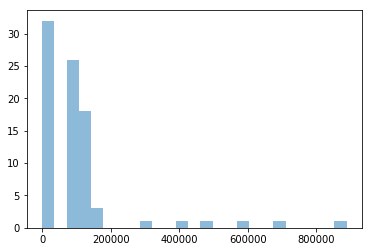

In [22]:
#x = azdias_copy.count
#print(x)
missing_cols = azdias_copy.isnull().sum()
plt.hist(missing_cols, bins = 25, alpha = 0.5)

In [23]:
len(missing_cols)

85

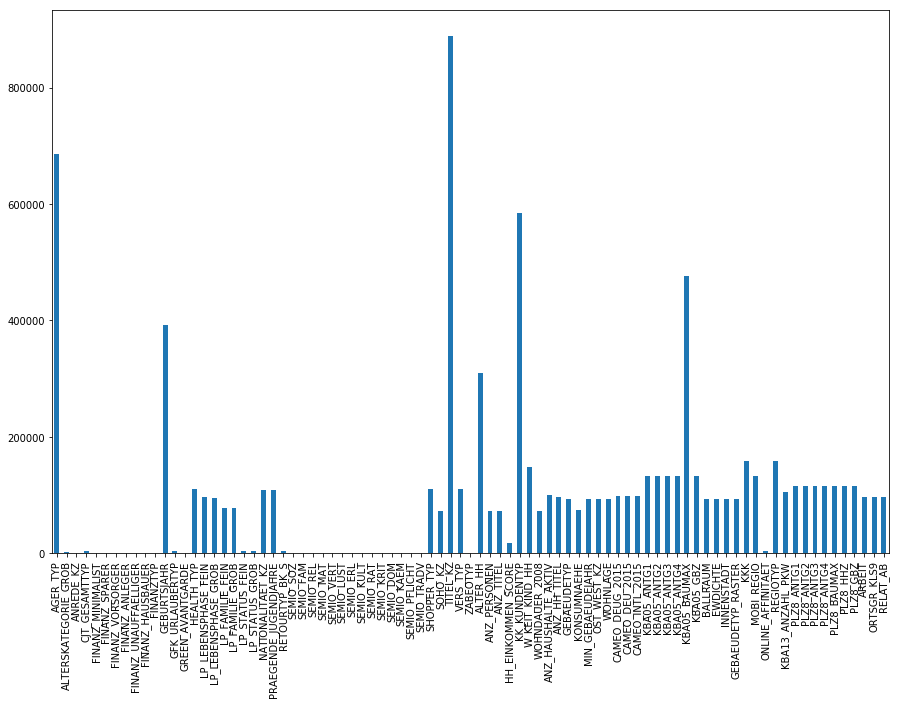

In [24]:
# Investigate patterns in the amount of missing data in each column.
missing_cols.plot.bar(figsize=(15,10))
plt.show()
#plt.hist(azdias_copy)

In [25]:

missing_20 = [col for col in azdias_copy.columns if (azdias_copy[col].isnull().sum()/azdias_copy.shape[0]) * 100 > 20]
print(missing_20)

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [26]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
outlier_cols = missing_20
for c in outlier_cols:
    print(c)
    del azdias_copy[c]
#azdias_copy = azdias_copy.drop(outlier_cols, axis = 1)

AGER_TYP
GEBURTSJAHR
TITEL_KZ
ALTER_HH
KK_KUNDENTYP
KBA05_BAUMAX


In [27]:
#azdias_copy.plot.bar(figsize=(15,10))
#plt.show()

In [28]:
azdias_copy['TITEL_KZ'] # to show the column has been dropped.

KeyError: 'TITEL_KZ'

#### Discussion 1.1.2: Assess Missing Data in Each Column

- Yes, some of the columns have large amount of missing data, hence the columns having more than 20% of the mssing data have been removed. I have chosen 20% as a benchmark just by observing the bar-chart plotted above of data columns containing missing values.  
- There was not a regular pattern in the missing values though.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [29]:
# How much data is missing in each row of the dataset?
missing_rows = azdias_copy.isnull().sum(axis=1)
missing_rows

0         43
1          0
2          0
3          7
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
19         0
20        10
21         0
22         0
23         8
24        47
25         5
26        19
27         0
28         0
29         2
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    14
891204     0
891205     0
891206     0
891207     0
891208     3
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64

In [30]:
missing_rows.value_counts().sort_values()

48         1
49         2
31         3
28         5
30         6
29        12
42        21
27        24
25        55
26        59
24        69
39        77
36        84
22       129
23       132
40       137
21       150
44       155
32       206
20       349
41       356
38       421
18       428
45       494
37       538
17       677
12       766
11      1127
19      1180
14      2243
16      2505
33      2985
9       3042
13      3255
35      3911
15      4743
10      5410
34     10816
4      12607
7      13714
6      13771
1      15738
3      17629
5      22515
8      24592
43     27369
2      27926
47     45578
0     623209
dtype: int64

In [31]:
print((missing_rows.value_counts().sort_index()))

0     623209
1      15738
2      27926
3      17629
4      12607
5      22515
6      13771
7      13714
8      24592
9       3042
10      5410
11      1127
12       766
13      3255
14      2243
15      4743
16      2505
17       677
18       428
19      1180
20       349
21       150
22       129
23       132
24        69
25        55
26        59
27        24
28         5
29        12
30         6
31         3
32       206
33      2985
34     10816
35      3911
36        84
37       538
38       421
39        77
40       137
41       356
42        21
43     27369
44       155
45       494
47     45578
48         1
49         2
dtype: int64


The above cell represents the number of missing values in the first column and the actual number of rows with those many entries missing in the second column.
- For example, there are 5,73,234 rows with 0 missing values i.e. no missing values present.

So a threshold of 24 missing values per row can be considered and the data can be divided into two different subsets.
- A threshold of 24 missing values was chosen as it is half of the maximum number of entries missing i.e. 48

In [32]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
rows_with_missing_few = missing_rows[missing_rows <= 24]
rows_with_missing_large = missing_rows[missing_rows > 24]
#print(rows_with_missing_large.value_counts().sort_index())
print(len(rows_with_missing_large))
print(len(rows_with_missing_few))
print(len(rows_with_missing_large) + len(rows_with_missing_few))

93315
797906
891221


In [33]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def compare_distribution(column_name):
    graph = plt.figure(figsize=(14,4))
    ax1 = graph.add_subplot(121)
    ax1.title.set_text('Rows with missing many entries')
    print(len(azdias_copy.loc[rows_with_missing_large.index,column_name]))
    sns.countplot(azdias_copy.loc[rows_with_missing_large.index,column_name])

    ax2 = graph.add_subplot(122)
    ax2.title.set_text('Rows with missing few entries')
    print(len(azdias_copy.loc[~azdias_copy.index.isin(rows_with_missing_large.index),column_name]))
    sns.countplot(azdias_copy.loc[~azdias_copy.index.isin(rows_with_missing_large.index),column_name]);

    #graph.suptitle(column_name)
    plt.show()

In [34]:
def compare_distribution_original(column_name):
    graph = plt.figure(figsize=(14,4))
    ax1 = graph.add_subplot(121)
    ax1.title.set_text('Rows with missing few entries')
    print(len(azdias_copy.loc[rows_with_missing_few.index, column_name]))
    sns.countplot(azdias_copy.loc[rows_with_missing_few.index, column_name])

    ax2 = graph.add_subplot(122)
    ax2.title.set_text('Original Rows')
    print(len(azdias_copy.loc[missing_rows.index, column_name]))
    sns.countplot(azdias_copy.loc[missing_rows.index, column_name]);

    graph.suptitle(column_name)
    plt.show()

93315
797906


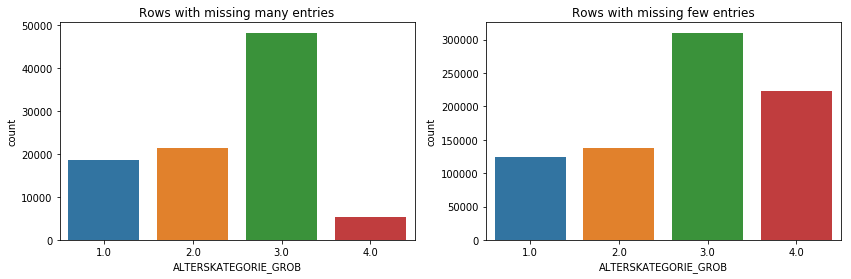

93315
797906


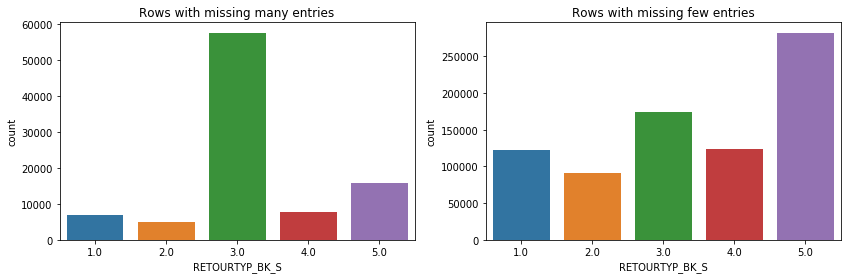

93315
797906


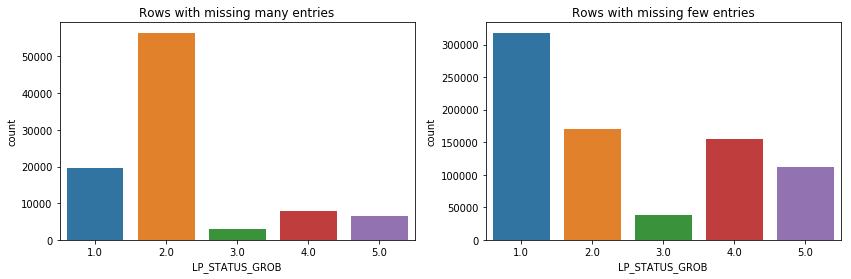

93315
797906


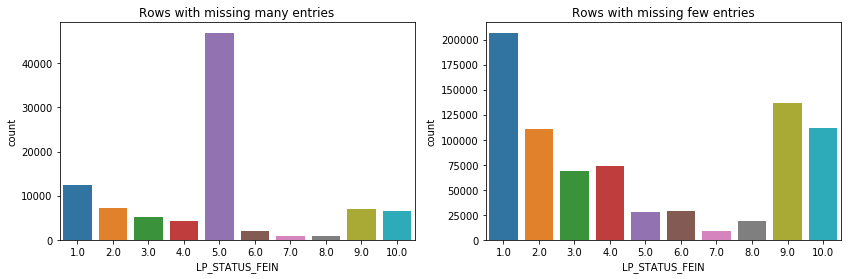

93315
797906


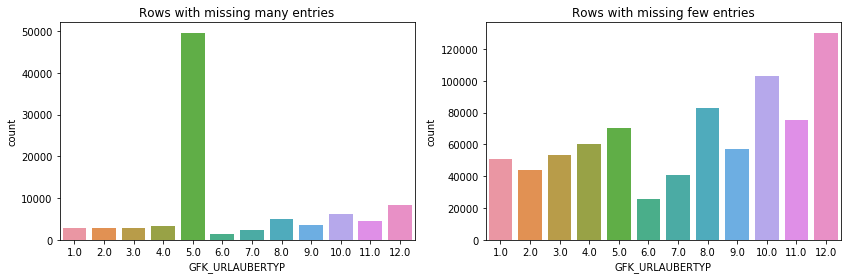

In [35]:
#col_names_with_few_missing_vals = ['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST', 'FINANZ_SPARER']
col_names_with_few_or_no_missing_vals = ['ALTERSKATEGORIE_GROB',     
'RETOURTYP_BK_S',             
'LP_STATUS_GROB',             
'LP_STATUS_FEIN',          
'GFK_URLAUBERTYP']
for coln in col_names_with_few_or_no_missing_vals:
    compare_distribution(coln)

797906
891221


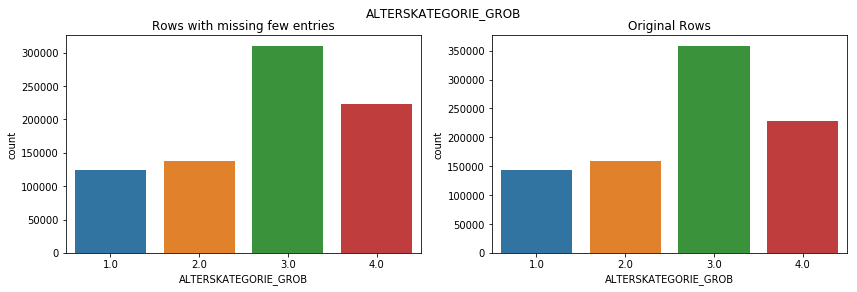

797906
891221


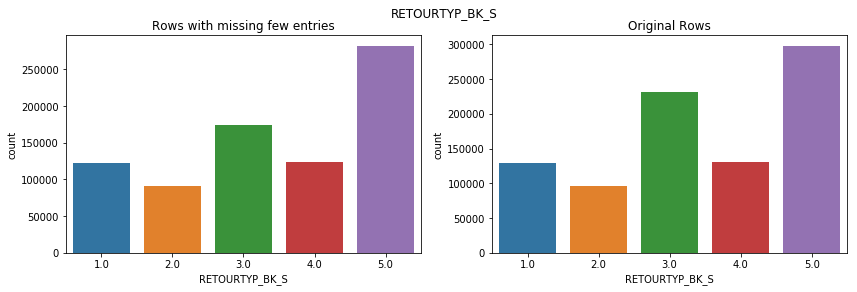

797906
891221


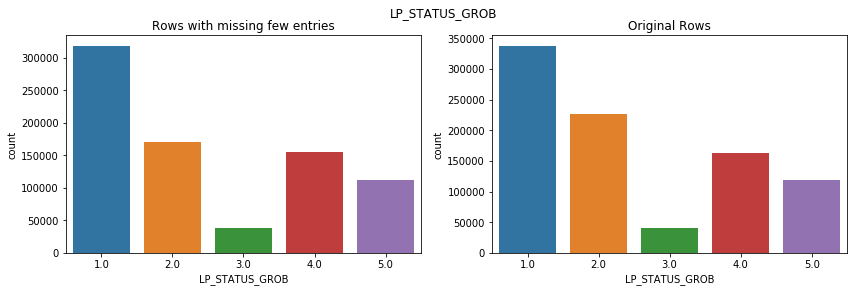

797906
891221


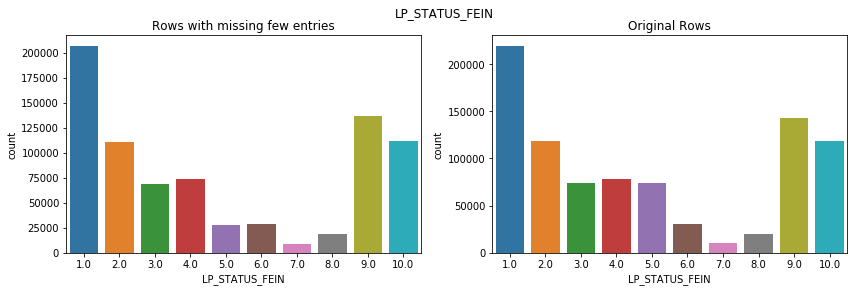

797906
891221


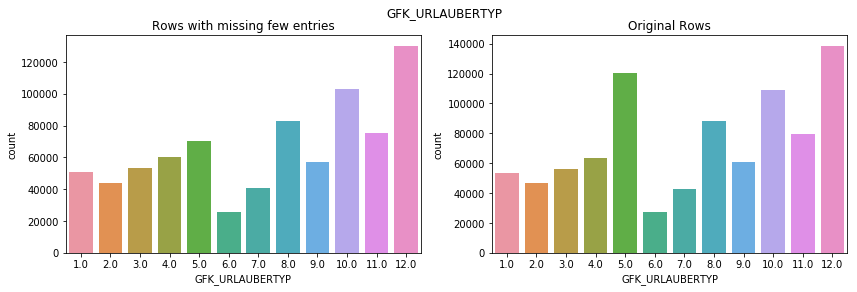

In [36]:
col_names_with_few_or_no_missing_vals = ['ALTERSKATEGORIE_GROB',     
'RETOURTYP_BK_S',             
'LP_STATUS_GROB',             
'LP_STATUS_FEIN',          
'GFK_URLAUBERTYP']
for coln in col_names_with_few_or_no_missing_vals:
    compare_distribution_original(coln)

In [37]:
# the rows with missing large number of entries have been dropped rather stored separately
azdias_many_missing_rows = azdias_copy.iloc[rows_with_missing_large.index]

In [38]:
# Drop rows with many missing values

print('Rows before dropping rows with missing vals:', azdias_copy.shape[0])

azdias_copy = azdias_copy[~azdias_copy.index.isin(rows_with_missing_large.index)]

print('Rows after dropping rows with missing vals:', azdias_copy.shape[0])

Rows before dropping rows with missing vals: 891221
Rows after dropping rows with missing vals: 797906


#### Discussion 1.1.3: Assess Missing Data in Each Row

- The data with lots of missing values are qualitatively different from data with few or no missing values.
- But when the data with few or no missing values was compared with the original data, there was much less difference between the charts.
- Hence, the rows with missing large number of entries have been dropped rather stored separately for further use if needed.
- A threshold of 24 missing values was chosen as it is half of the maximum number of entries missing i.e. 48

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [39]:
outlier_cols

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [40]:
# firstly, remove the outlier columns which have been removed from the azdias_copy dataset
for x in outlier_cols:
    feat_info = feat_info[feat_info.attribute != x]

In [41]:
# How many features are there of each data type?
feat_info['type'].value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

In [42]:
feat_info

,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]
10,FINANZTYP,person,categorical,[-1]


In [43]:
#azdias

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [44]:
#azdias_copy

In [45]:
feat_info[feat_info['type'] == 'categorical']

,attribute,information_level,type,missing_or_unknown
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]
21,NATIONALITAET_KZ,person,categorical,"[-1,0]"


In [46]:
cat_vars = azdias_copy[feat_info[feat_info['type'] == 'categorical']['attribute']]
cat_vars

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
1,2,5.0,1,10.0,0,5.0,3.0,2.0,1.0,1.0,3.0,1.0,2.0,5,8.0,W,8,8A
2,2,3.0,1,10.0,1,1.0,1.0,3.0,2.0,1.0,2.0,0.0,1.0,5,1.0,W,4,4C
3,2,2.0,6,1.0,0,NaN,NaN,9.0,4.0,1.0,1.0,0.0,1.0,3,1.0,W,2,2A
4,1,5.0,5,5.0,0,10.0,5.0,3.0,2.0,1.0,2.0,0.0,2.0,4,1.0,W,6,6B
5,2,2.0,2,1.0,0,1.0,1.0,4.0,2.0,1.0,0.0,0.0,2.0,4,1.0,W,8,8C
6,2,5.0,4,12.0,0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,4,1.0,W,4,4A
7,1,3.0,5,9.0,0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1,8.0,W,2,2D
8,1,3.0,6,3.0,1,1.0,1.0,10.0,5.0,1.0,3.0,0.0,2.0,6,3.0,W,1,1A
9,2,4.0,1,12.0,1,1.0,1.0,3.0,2.0,1.0,3.0,0.0,2.0,4,3.0,W,1,1E
10,2,1.0,6,8.0,0,1.0,1.0,1.0,1.0,1.0,2.0,0.0,2.0,3,1.0,W,9,9D


In [47]:
cat_vars['ANREDE_KZ'].value_counts()

2    416089
1    381817
Name: ANREDE_KZ, dtype: int64

In [48]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

for x in cat_vars:
    print(cat_vars[x].value_counts().sort_index())

1    381817
2    416089
Name: ANREDE_KZ, dtype: int64
1.0     93306
2.0    141260
3.0    147203
4.0    198280
5.0    111104
6.0    102075
Name: CJT_GESAMTTYP, dtype: int64
1    197117
2    104748
3     44757
4     55916
5    106321
6    289047
Name: FINANZTYP, dtype: int64
1.0      50656
2.0      43826
3.0      53101
4.0      60422
5.0      70498
6.0      25738
7.0      40678
8.0      83028
9.0      57124
10.0    102823
11.0     75099
12.0    130235
Name: GFK_URLAUBERTYP, dtype: int64
0    622698
1    175208
Name: GREEN_AVANTGARDE, dtype: int64
1.0     402538
2.0      98548
3.0       4688
4.0      11574
5.0      11167
6.0       8526
7.0      19575
8.0      21780
9.0      10452
10.0    128966
11.0     48744
Name: LP_FAMILIE_FEIN, dtype: int64
1.0    402538
2.0     98548
3.0     27429
4.0     49881
5.0    188162
Name: LP_FAMILIE_GROB, dtype: int64
1.0     206852
2.0     111100
3.0      68917
4.0      73969
5.0      27582
6.0      28894
7.0       9203
8.0      18794
9.0     136344
10.0   

In [49]:
# OST_WEST_KZ is the attribute that takes on non-numeric values.
#cat_vars = pd.get_dummies(cat_vars, columns = ['OST_WEST_KZ'])
azdias_copy = pd.get_dummies(azdias_copy, columns = ['OST_WEST_KZ'])
del azdias_copy['OST_WEST_KZ_W']

In [50]:
#azdias_copy['OST_WEST_KZ']

In [51]:
azdias_copy['OST_WEST_KZ_O'].value_counts()

0    629388
1    168518
Name: OST_WEST_KZ_O, dtype: int64

In [52]:
# Re-encode categorical variable(s) to be kept in the analysis.
multi_var = []
for x in cat_vars:
    if (len(cat_vars[x].value_counts()) > 2):
        multi_var.append(x)
print(multi_var)

['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [53]:
for mul in multi_var:
    print(mul)
    del azdias_copy[mul]
    #azdias_copy.drop(mul, axis = 1)

CJT_GESAMTTYP
FINANZTYP
GFK_URLAUBERTYP
LP_FAMILIE_FEIN
LP_FAMILIE_GROB
LP_STATUS_FEIN
LP_STATUS_GROB
NATIONALITAET_KZ
SHOPPER_TYP
ZABEOTYP
GEBAEUDETYP
CAMEO_DEUG_2015
CAMEO_DEU_2015


In [54]:
#azdias_copy['CAMEO_DEU_2015']

#### Discussion 1.2.1: Re-Encode Categorical Features


- Before starting, I dropped the rows in feat_info table which were the columns dropped in the azdias_copy dataset with many missing values.
- Then I took the count of categorical features. And took only these categorical features in the separate cat_vars dataframe.
- Next step was to find which of these cat_vars are binary / multi-level. There was no need to encode the binary vars, one var viz. OST_WEST_KZ was textual which is now converted to numeric using One Hot Encoding method(pandas - get_dummies)
- To keep things simple, I have dropped the multi-level categorical columns from the azdias_copy dataset

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [55]:
feat_info[feat_info['type'] == 'mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [56]:
azdias_copy['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    182964
8.0     141598
10.0     85793
5.0      84682
3.0      53840
15.0     42540
11.0     35746
9.0      33569
6.0      25652
12.0     24446
1.0      20678
4.0      20451
2.0       7479
13.0      5762
7.0       4009
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [57]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_copy['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] =  azdias_copy['PRAEGENDE_JUGENDJAHRE']


In [58]:
#azdias_copy = pd.get_dummies(azdias_copy, columns = ['PRAEGENDE_JUGENDJAHRE_MOVEMENT'])

In [59]:
azdias_copy['PRAEGENDE_JUGENDJAHRE_MOVEMENT']

1         14.0
2         15.0
3          8.0
4          8.0
5          3.0
6         10.0
7          8.0
8         11.0
9         15.0
10         3.0
12         8.0
13        15.0
15         5.0
16        14.0
18        10.0
19         9.0
20        11.0
21        10.0
22        14.0
23         9.0
25        14.0
26         8.0
27        11.0
28        10.0
29         6.0
31        10.0
32        15.0
33         8.0
34         4.0
36         8.0
          ... 
891191     3.0
891192    14.0
891193     5.0
891194    11.0
891195     8.0
891196    14.0
891197    11.0
891198    15.0
891199    10.0
891200    14.0
891201    10.0
891202    10.0
891203     NaN
891204    10.0
891205     3.0
891206    14.0
891207     2.0
891208     8.0
891209    14.0
891210     8.0
891211     8.0
891212     3.0
891213    11.0
891214    14.0
891215    10.0
891216    14.0
891217    10.0
891218    14.0
891219    14.0
891220     3.0
Name: PRAEGENDE_JUGENDJAHRE_MOVEMENT, Length: 797906, dtype: float64

In [60]:
len(azdias_copy['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].values)

797906

In [61]:
vals_to_replace = {1:0, 2:1, 3:0, 4:1, 5:0, 
                   6:1, 7:1, 8:0, 9:1, 10:0,
                  11:1, 12:0, 13:1, 14:0, 15:1}
azdias_copy['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias_copy['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].map(vals_to_replace)

In [62]:
azdias_copy['PRAEGENDE_JUGENDJAHRE_MOVEMENT']

1         0.0
2         1.0
3         0.0
4         0.0
5         0.0
6         0.0
7         0.0
8         1.0
9         1.0
10        0.0
12        0.0
13        1.0
15        0.0
16        0.0
18        0.0
19        1.0
20        1.0
21        0.0
22        0.0
23        1.0
25        0.0
26        0.0
27        1.0
28        0.0
29        1.0
31        0.0
32        1.0
33        0.0
34        1.0
36        0.0
         ... 
891191    0.0
891192    0.0
891193    0.0
891194    1.0
891195    0.0
891196    0.0
891197    1.0
891198    1.0
891199    0.0
891200    0.0
891201    0.0
891202    0.0
891203    NaN
891204    0.0
891205    0.0
891206    0.0
891207    1.0
891208    0.0
891209    0.0
891210    0.0
891211    0.0
891212    0.0
891213    1.0
891214    0.0
891215    0.0
891216    0.0
891217    0.0
891218    0.0
891219    0.0
891220    0.0
Name: PRAEGENDE_JUGENDJAHRE_MOVEMENT, Length: 797906, dtype: float64

In [63]:
len(azdias_copy['PRAEGENDE_JUGENDJAHRE_MOVEMENT'])

797906

In [64]:
azdias_copy['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias_copy['PRAEGENDE_JUGENDJAHRE']

In [65]:
vals_to_replace = {1:1, 2:1, 3:2, 4:2, 5:3, 
                   6:3, 7:3, 8:4, 9:4, 10:5,
                  11:5, 12:5, 13:5, 14:6, 15:6}
azdias_copy['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias_copy['PRAEGENDE_JUGENDJAHRE_DECADE'].map(vals_to_replace)

In [66]:
azdias_copy['PRAEGENDE_JUGENDJAHRE_DECADE']

1         6.0
2         6.0
3         4.0
4         4.0
5         2.0
6         5.0
7         4.0
8         5.0
9         6.0
10        2.0
12        4.0
13        6.0
15        3.0
16        6.0
18        5.0
19        4.0
20        5.0
21        5.0
22        6.0
23        4.0
25        6.0
26        4.0
27        5.0
28        5.0
29        3.0
31        5.0
32        6.0
33        4.0
34        2.0
36        4.0
         ... 
891191    2.0
891192    6.0
891193    3.0
891194    5.0
891195    4.0
891196    6.0
891197    5.0
891198    6.0
891199    5.0
891200    6.0
891201    5.0
891202    5.0
891203    NaN
891204    5.0
891205    2.0
891206    6.0
891207    1.0
891208    4.0
891209    6.0
891210    4.0
891211    4.0
891212    2.0
891213    5.0
891214    6.0
891215    5.0
891216    6.0
891217    5.0
891218    6.0
891219    6.0
891220    2.0
Name: PRAEGENDE_JUGENDJAHRE_DECADE, Length: 797906, dtype: float64

In [67]:
del azdias_copy['PRAEGENDE_JUGENDJAHRE']
#azdias_copy.drop('PRAEGENDE_JUGENDJAHRE', axis = 1)

In [68]:
azdias_copy['CAMEO_INTL_2015'].isnull().sum()

6106

In [69]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_copy['CAMEO_INTL_2015_HOUSEHOLDS'] = azdias_copy['CAMEO_INTL_2015'] 
azdias_copy['CAMEO_INTL_2015_LIFE_STG'] = azdias_copy['CAMEO_INTL_2015']

In [70]:
vals_to_replace = {'11':'1', '12':'1', '13':'1', '14':'1', '15':'1',
                   '21':'2', '22':'2', '23':'2', '24':'2', '25':'2',
                   '31':'3', '32':'3', '33':'3', '34':'3', '35':'3',
                   '41':'4', '42':'4', '43':'4', '44':'4', '45':'4',
                   '51':'5', '52':'5', '53':'5', '54':'5', '55':'5'}
azdias_copy['CAMEO_INTL_2015_HOUSEHOLDS'] = azdias_copy['CAMEO_INTL_2015_HOUSEHOLDS'].map(vals_to_replace)

In [71]:
vals_to_replace = {'11':'1', '12':'2', '13':'3', '14':'4', '15':'5',
                   '21':'1', '22':'2', '23':'3', '24':'4', '25':'5',
                   '31':'1', '32':'2', '33':'3', '34':'4', '35':'5',
                   '41':'1', '42':'2', '43':'3', '44':'4', '45':'5',
                   '51':'1', '52':'2', '53':'3', '54':'4', '55':'5'}
azdias_copy['CAMEO_INTL_2015_LIFE_STG'] = azdias_copy['CAMEO_INTL_2015_LIFE_STG'].map(vals_to_replace)

In [72]:
azdias_copy['CAMEO_INTL_2015_HOUSEHOLDS'].value_counts()

5    223577
2    190652
4    189959
1    119431
3     68181
Name: CAMEO_INTL_2015_HOUSEHOLDS, dtype: int64

In [73]:
azdias_copy['CAMEO_INTL_2015_LIFE_STG'].value_counts()

1    245039
4    232761
3    119670
5    117040
2     77290
Name: CAMEO_INTL_2015_LIFE_STG, dtype: int64

In [74]:
azdias_copy['CAMEO_INTL_2015_LIFE_STG'].isnull().sum()

6106

In [75]:
del azdias_copy['CAMEO_INTL_2015']
#azdias_copy.drop('CAMEO_INTL_2015', axis = 1)

#### Discussion 1.2.2: Engineer Mixed-Type Features


- Using the simple map() function I have re-engineered two new columns for each of the given columns viz. `PRAEGENDE_JUGENDJAHRE` and `CAMEO_INTL_2015`
- Talking about the 'PRAEGENDE_JUGENDJAHRE' column, I have made two new columns and dropped the original one. 
The columns are `PRAEGENDE_JUGENDJAHRE_MOVEMENT`(binary) where 0 represents the movement is mainstream and 1 represents the movement is avantgarde and `PRAEGENDE_JUGENDJAHRE_DECADE`(multi-level) where each of the digits represent the decades starting from the 40s to 90s.
- And the second `CAMEO_INT_2015` is dropped and two new columns are introduced as `CAMEO_INT_2015_HOUSEHOLD`(multi-level) where the levels represent different conditions from Wealthy to Poorer and the second `CAMEO_INT_2015_LIFE_STG`(multi-level) where the levels represent different stages of a family from Couples and Singles to Elders in Retirement
- I will be dropping the rest mixed attributes in the next section for simplicity.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [76]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

mixed_cat = ['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'WOHNLAGE',
 'PLZ8_BAUMAX']

In [77]:
for mul in mixed_cat:
    del azdias_copy[mul]
    #azdias_copy.drop(mul, axis = 1)

In [78]:
feat_info['type'].value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

In [79]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
len(azdias_copy.columns)

64

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [80]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    df_copy = df
    # Identify missing or unknown data values and convert them to NaNs.
    feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep = ';')
    #for i, column in list(enumerate(df_copy.columns)):
        
     #   vals = feat_info['missing_or_unknown'].iloc[i]
      #  if i in [57, 58, 59]: # since only these are in object type, manual detection of col-number from counter_list
       #     a = vals.strip("[]").split(",")
        #print(a)
        #else:
         #   try:
            
          #      if (type(df_copy[column][0]) == np.float64):
           #         b = vals.strip("[]").split(",")
            #        a = [float(e) for e in b]
             #   else:
              #      b = vals.strip("[]").split(",")
               #     a = [int(e) for e in b]
            #except ValueError: # ValueError will rise if the field is blank
             #   pass
        #for re in a:
         #   df_copy[column].replace(re, np.NaN, inplace = True)
    for index, row in feat_info.iterrows():
        column = df_copy[row['attribute']]

        missing_values = row['missing_or_unknown'][1:-1].split(',')
        if missing_values != ['']:
            for mv in missing_values:
                if mv != 'X' and mv != 'XX':
                    column.replace(int(mv), np.nan, inplace = True)
                else:
                    column.replace(mv, np.nan, inplace = True)

        df_copy[row['attribute']] = column
    
    # remove selected columns and rows, ...
    # columns
    # Before I had chosen 20%, but after thorough checking of the customers data,
    # I have incread the same benchmark to 50%
    missing_50 = [col for col in df_copy.columns if (df_copy[col].isnull().sum()/df_copy.shape[0]) * 100 > 50]
    for m in missing_50:
        del df_copy[m]
    #df_copy = df_copy.drop(missing_20, axis = 1)
    # rows
    missing_rows = df_copy.isnull().sum(axis=1)
    rows_with_missing_large = missing_rows[missing_rows > 24]
    print('Rows before dropping rows with missing vals:', df_copy.shape[0])
    df_copy = df_copy[~df_copy.index.isin(rows_with_missing_large.index)]
    print('Rows after dropping rows with missing vals:', df_copy.shape[0])
    # select, re-encode, and engineer column values.
    for x in missing_20:
        feat_info = feat_info[feat_info.attribute != x]
    cat_vars = df_copy[feat_info[feat_info['type'] == 'categorical']['attribute']]
    #print(df_copy.columns)
    df_copy = pd.get_dummies(df_copy, columns = ['OST_WEST_KZ'])
    del df_copy['OST_WEST_KZ_W']
    multi_var = []
    for x in cat_vars:
        if (len(cat_vars[x].value_counts()) > 2):
            multi_var.append(x)
    for mul in multi_var:
        del df_copy[mul]
        #df_copy.drop(mul, axis = 1)
    df_copy['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] =  df_copy['PRAEGENDE_JUGENDJAHRE']
    df_copy['PRAEGENDE_JUGENDJAHRE_DECADE'] = df_copy['PRAEGENDE_JUGENDJAHRE']
    vals_to_replace = {1:0, 2:1, 3:0, 4:1, 5:0, 
                   6:1, 7:1, 8:0, 9:1, 10:0,
                  11:1, 12:0, 13:1, 14:0, 15:1}
    df_copy['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df_copy['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].map(vals_to_replace)
    vals_to_replace = {1:1, 2:1, 3:2, 4:2, 5:3, 
                   6:3, 7:3, 8:4, 9:4, 10:5,
                  11:5, 12:5, 13:5, 14:6, 15:6}
    df_copy['PRAEGENDE_JUGENDJAHRE_DECADE'] = df_copy['PRAEGENDE_JUGENDJAHRE_DECADE'].map(vals_to_replace)
    del df_copy['PRAEGENDE_JUGENDJAHRE']
    #df_copy.drop('PRAEGENDE_JUGENDJAHRE', axis = 1)
    df_copy['CAMEO_INTL_2015_HOUSEHOLDS'] = df_copy['CAMEO_INTL_2015'] 
    df_copy['CAMEO_INTL_2015_LIFE_STG'] = df_copy['CAMEO_INTL_2015']
    vals_to_replace = {'11':'1', '12':'1', '13':'1', '14':'1', '15':'1',
                   '21':'2', '22':'2', '23':'2', '24':'2', '25':'2',
                   '31':'3', '32':'3', '33':'3', '34':'3', '35':'3',
                   '41':'4', '42':'4', '43':'4', '44':'4', '45':'4',
                   '51':'5', '52':'5', '53':'5', '54':'5', '55':'5'}
    df_copy['CAMEO_INTL_2015_HOUSEHOLDS'] = df_copy['CAMEO_INTL_2015_HOUSEHOLDS'].map(vals_to_replace)
    vals_to_replace = {'11':'1', '12':'2', '13':'3', '14':'4', '15':'5',
                   '21':'1', '22':'2', '23':'3', '24':'4', '25':'5',
                   '31':'1', '32':'2', '33':'3', '34':'4', '35':'5',
                   '41':'1', '42':'2', '43':'3', '44':'4', '45':'5',
                   '51':'1', '52':'2', '53':'3', '54':'4', '55':'5'}
    df_copy['CAMEO_INTL_2015_LIFE_STG'] = df_copy['CAMEO_INTL_2015_LIFE_STG'].map(vals_to_replace)
    del df_copy['CAMEO_INTL_2015']
    #df_copy.drop('CAMEO_INTL_2015', axis = 1)
    mixed_cat = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX']
    for mul in mixed_cat:
        del df_copy[mul]
        #df_copy.drop(mul, axis = 1)
    # Return the cleaned dataframe.
    return df_copy
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [81]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
azdias_copy.isnull().sum().describe()


count       64.000000
mean     11879.843750
std      18006.765171
min          0.000000
25%          0.000000
50%        592.000000
75%      23200.000000
max      64764.000000
dtype: float64

In [82]:
#azdias_copy['CAMEO_DEU_2015']

In [83]:
#from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values = 'NaN', strategy = 'median')
azdias_imputed = pd.DataFrame(imputer.fit_transform(azdias_copy), index = azdias_copy.index, columns = azdias_copy.columns)

In [84]:
azdias_imputed.shape

(797906, 64)

In [85]:
azdias_imputed.isnull().sum().value_counts()

0    64
dtype: int64

In [86]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_imputed), index = azdias_imputed.index, columns = azdias_imputed.columns)


### Discussion 2.1: Apply Feature Scaling


- Applied the describe() function to the `AZDIAS` dataset to check the distributions of missing values.
- Checked if it has been applied correctly so that no missing values are present.
- Made a decision to use the Imputer function to replace the missing values with the median of the column i.e. the middle value of the column since the dataset is repititive(i.e. there is repitition of values).
- Further, used the StandardScaler and stored it into the `azdias_scaled` dataframe.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [87]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca = PCA()
azdias_scaled_pca = pca.fit_transform(azdias_scaled)

In [88]:
print(pca.score(azdias_scaled))

-inf


In [89]:
# took help from the code provided in the classroom for this function.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

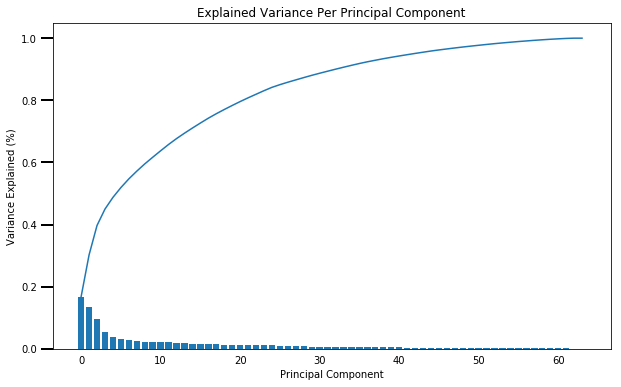

In [90]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca)


In [91]:
pca1 = PCA(n_components = 39)
azdias_scaled_pca1 = pca1.fit_transform(azdias_scaled)

In [92]:
print(pca1.score(azdias_scaled)) # prints negative average log-likelihood score

-67.4582296476


In [93]:
pca2 = PCA(n_components = 28)
azdias_scaled_pca2 = pca2.fit_transform(azdias_scaled)

In [94]:
print(pca2.score(azdias_scaled))

-69.0101002513


In [95]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca3 = PCA(n_components = 21)
azdias_scaled_pca3 = pca3.fit_transform(azdias_scaled)

In [96]:
#scree_plot(pca)
print(pca3.score(azdias_scaled))

-70.8000071582


### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)
- I am retaining 28 features for further analysis becuase I took the negative log-likelihood score of the Principal Component Analysis and came to the conculsion that I want to retain a decent amount of features hence cannot lose more features for my analysis. Although with 21 components a good score is received I have decided to go with 28 features.
- The screeplot has been written with the help of the code taught in the classroom. And using this plot, we can see there is small deviation near 20, 30, and 40.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [97]:
import operator # since I have to use itemgetter() function in the sorting step
# https://stackoverflow.com/questions/18595686/how-does-operator-itemgetter-and-sort-work-in-python reference
def pca_link_weights(pca, i):
    map_wt = {}
    for counter, feature in enumerate(azdias_copy.columns):
        # mapping step
        map_wt[feature] = pca.components_[i][counter]
    
    # sorting step
    sorted_weights = sorted(map_wt.items(), key = operator.itemgetter(1), reverse=True)
    
    return sorted_weights

In [98]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

pca_link_weights(pca2, 1)

[('ALTERSKATEGORIE_GROB', 0.26110705676504575),
 ('FINANZ_VORSORGER', 0.23391564122329941),
 ('SEMIO_ERL', 0.23145407634017168),
 ('SEMIO_LUST', 0.18442301436726025),
 ('RETOURTYP_BK_S', 0.16395999136698036),
 ('W_KEIT_KIND_HH', 0.11935205917499146),
 ('FINANZ_HAUSBAUER', 0.11599590454454743),
 ('SEMIO_KRIT', 0.115487292200114),
 ('SEMIO_KAEM', 0.11206071722227066),
 ('ANREDE_KZ', 0.090463018984169863),
 ('EWDICHTE', 0.088565531716314164),
 ('PLZ8_ANTG3', 0.088122800902359452),
 ('ORTSGR_KLS9', 0.087034637970134623),
 ('PLZ8_ANTG4', 0.084083273811133341),
 ('CAMEO_INTL_2015_HOUSEHOLDS', 0.071540840788634832),
 ('SEMIO_DOM', 0.070877136637171601),
 ('KBA05_ANTG4', 0.069481965525319767),
 ('FINANZ_MINIMALIST', 0.068151772001478053),
 ('ARBEIT', 0.065230732094304564),
 ('RELAT_AB', 0.062807259840391316),
 ('WOHNDAUER_2008', 0.061253856730555258),
 ('ANZ_HAUSHALTE_AKTIV', 0.061201599335518657),
 ('PLZ8_ANTG2', 0.061029469256412297),
 ('HH_EINKOMMEN_SCORE', 0.054092535269399646),
 ('KBA05_A

In [99]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_link_weights(pca2, 2)


[('SEMIO_VERT', 0.34507872473537776),
 ('SEMIO_SOZ', 0.26214096596451425),
 ('SEMIO_FAM', 0.24973283536069854),
 ('SEMIO_KULT', 0.23493326454338476),
 ('FINANZ_MINIMALIST', 0.15593757999733626),
 ('RETOURTYP_BK_S', 0.10892197750817711),
 ('FINANZ_VORSORGER', 0.10144152898825924),
 ('W_KEIT_KIND_HH', 0.091332325443531759),
 ('ALTERSKATEGORIE_GROB', 0.079385998509173994),
 ('SEMIO_REL', 0.069154123803737186),
 ('SEMIO_LUST', 0.064832115038093108),
 ('SEMIO_MAT', 0.055671741821490747),
 ('GREEN_AVANTGARDE', 0.047427291437126387),
 ('PRAEGENDE_JUGENDJAHRE_MOVEMENT', 0.047427291437126387),
 ('ORTSGR_KLS9', 0.046736508904619521),
 ('EWDICHTE', 0.046114131120888475),
 ('PLZ8_ANTG4', 0.045214033107575463),
 ('PLZ8_ANTG3', 0.044892571458893242),
 ('ARBEIT', 0.035000018517157061),
 ('WOHNDAUER_2008', 0.032945022203138878),
 ('RELAT_AB', 0.031923674227328287),
 ('PLZ8_ANTG2', 0.030099683697357552),
 ('KBA05_ANTG4', 0.028456719278492311),
 ('CAMEO_INTL_2015_HOUSEHOLDS', 0.027774277116518076),
 ('A

In [100]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_link_weights(pca2, 3)

[('GREEN_AVANTGARDE', 0.40012032662057101),
 ('PRAEGENDE_JUGENDJAHRE_MOVEMENT', 0.40012032662057101),
 ('EWDICHTE', 0.2623517094151645),
 ('ORTSGR_KLS9', 0.24974069949625716),
 ('PLZ8_HHZ', 0.13865597261378909),
 ('ONLINE_AFFINITAET', 0.13656672725306829),
 ('SEMIO_DOM', 0.11241780570869039),
 ('PLZ8_ANTG2', 0.10729585835515491),
 ('PLZ8_ANTG3', 0.10225062298266271),
 ('ANZ_PERSONEN', 0.098698565613639239),
 ('RELAT_AB', 0.096919535862765291),
 ('KBA05_ANTG1', 0.094259588557912596),
 ('PLZ8_ANTG4', 0.08346175013188685),
 ('FINANZ_UNAUFFAELLIGER', 0.08026289665489228),
 ('SEMIO_KAEM', 0.077558215487971288),
 ('FINANZ_MINIMALIST', 0.066086771766083574),
 ('MOBI_REGIO', 0.062084202377312887),
 ('SEMIO_TRADV', 0.060573440732682157),
 ('CAMEO_INTL_2015_LIFE_STG', 0.057770291592102022),
 ('ARBEIT', 0.054949294115727965),
 ('KBA05_GBZ', 0.053238616596132493),
 ('SEMIO_RAT', 0.051075914419073873),
 ('KBA13_ANZAHL_PKW', 0.049377132606535548),
 ('ANZ_TITEL', 0.04898544331499758),
 ('PRAEGENDE_JU

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)
- Yes, we can interpret positive and negative values from the detailed investigation of the first few principal components generated in a meaningful way.
- For example, in the first Principal Component generated, `SEMIO_ERL` & `FINANZ_VORSORGER` have almost equal weights. From the Data Dictionary, `SEMIO_ERL` is **Personality typology** for _**event oriented**_ people and `FINANZ_VORSORGER` is **Financial typology** for people in the _**be prepared**_ category, i.e. we can conclude the fact that people with event oriented personality are prepared for any event that might come across maybe financially or in any other way.
- In the second Principal Component generated, `PLZ8_ANTG4`, `PLZ8_ANTG3`, `ORTSGR_KLS9` have almost common weights.
Each of the columns stand for __'Number of 6-10 family houses in the PLZ8 region', 'Number of 10+ family houses in the PLZ8 region', 'Size of community'__ respectively. That means as the number of family houses increase in a particular region the size of community also increases. This statement is nothing but an obvious fact.
- In the third Principal Component generated, `FINANZ_HAUSBAUER` & `CAMEO_INTL_2015_HOUSEHOLDS` have  weights almost near to each other. This tells us that 'German Wealth Typology'(`CAMEO_INTL_2015_HOUSEHOLDS`) and 'German Financial Typology for people who own the Homes'(`FINANZ_HAUSBAUER`) are related i.e. __as the person's wealth increases, his/hers chances of owning his/her own Home also increases.__

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [101]:
from sklearn.cluster import KMeans
# Over a number of different cluster counts...
model_score = []
cluster_centers = [2, 5, 8, 12, 15, 18, 20, 23] # chosen arbitrarily
for i in cluster_centers:

    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=i, random_state=0).fit(azdias_scaled_pca2)
    
    # compute the average within-cluster distances.
    score = np.abs(kmeans.score(azdias_scaled_pca2)) # taking absolute value since the score will be negative.
    model_score.append(score)
    print("Number of Clusters = ", i, ", Score = ", score)
    

Number of Clusters =  2 , Score =  37767569.7305
Number of Clusters =  5 , Score =  30927123.4274
Number of Clusters =  8 , Score =  27689245.4083
Number of Clusters =  12 , Score =  25632117.2863
Number of Clusters =  15 , Score =  24452891.3835
Number of Clusters =  18 , Score =  23282699.2353
Number of Clusters =  20 , Score =  22670145.1102
Number of Clusters =  23 , Score =  21926358.9486


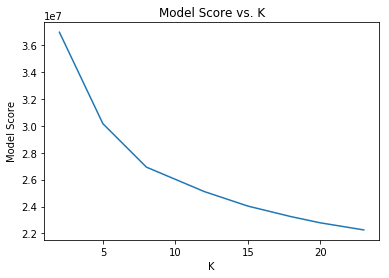

In [102]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
model_score = [36952034.3838, 30155792.2825, 26929714.6163, 25110874.5613, 24034416.6325,
              23245432.0463, 22789939.0319, 22262675.4181]
plt.plot(cluster_centers, model_score);
plt.xlabel('K');
plt.ylabel('Model Score');
plt.title('Model Score vs. K');

In [103]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans_8 =  KMeans(n_clusters=8, random_state=0).fit(azdias_scaled_pca2)
kmeans_predict = kmeans_8.predict(azdias_scaled_pca2)

### Discussion 3.1: Apply Clustering to General Population


- I have decided to segment the population into 8 cluster since from the graph we can see the elbow figure at `k = 8`.
- The scores have also been printed and there is a great decrease from k=2 to k=8 of ~10 units. Hence I have chosen k=8.
- The absolute value of the score has been taken to eliminate the negative sign and also since we are interested in the magnitude.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [104]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep = ';')

In [105]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 85 columns):
AGER_TYP                 191652 non-null int64
ALTERSKATEGORIE_GROB     191652 non-null int64
ANREDE_KZ                191652 non-null int64
CJT_GESAMTTYP            188439 non-null float64
FINANZ_MINIMALIST        191652 non-null int64
FINANZ_SPARER            191652 non-null int64
FINANZ_VORSORGER         191652 non-null int64
FINANZ_ANLEGER           191652 non-null int64
FINANZ_UNAUFFAELLIGER    191652 non-null int64
FINANZ_HAUSBAUER         191652 non-null int64
FINANZTYP                191652 non-null int64
GEBURTSJAHR              191652 non-null int64
GFK_URLAUBERTYP          188439 non-null float64
GREEN_AVANTGARDE         191652 non-null int64
HEALTH_TYP               191652 non-null int64
LP_LEBENSPHASE_FEIN      188439 non-null float64
LP_LEBENSPHASE_GROB      188439 non-null float64
LP_FAMILIE_FEIN          188439 non-null float64
LP_FAMILIE_GROB          188439 n

In [106]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_clean = clean_data(customers)
customers_clean

Rows before dropping rows with missing vals: 191652
Rows after dropping rows with missing vals: 141693


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_2015_HOUSEHOLDS,CAMEO_INTL_2015_LIFE_STG
0,4.0,1,5,1,5,1,2,2,NaN,1,...,5.0,5.0,1.0,2.0,1.0,0,1.0,2.0,1,3
2,4.0,2,5,1,5,1,4,4,NaN,1,...,3.0,2.0,3.0,5.0,3.0,0,1.0,2.0,3,4
3,4.0,1,5,1,5,2,1,2,NaN,0,...,3.0,4.0,1.0,3.0,1.0,0,0.0,1.0,2,4
4,3.0,1,3,1,4,4,5,2,1960.0,0,...,3.0,3.0,3.0,5.0,1.0,0,0.0,4.0,4,1
5,3.0,1,5,1,5,1,2,3,NaN,1,...,5.0,5.0,3.0,7.0,5.0,0,1.0,2.0,3,4
6,4.0,1,5,1,5,1,1,2,1942.0,1,...,5.0,5.0,2.0,3.0,2.0,0,1.0,2.0,2,3
7,4.0,1,5,1,5,1,2,2,1938.0,1,...,3.0,3.0,3.0,4.0,3.0,0,1.0,2.0,1,5
8,4.0,2,2,2,5,1,1,5,1914.0,0,...,5.0,4.0,3.0,8.0,3.0,0,0.0,1.0,5,5
9,3.0,1,5,2,4,1,3,1,1959.0,1,...,5.0,5.0,3.0,6.0,4.0,0,1.0,4.0,1,5
11,4.0,1,5,1,5,1,3,2,1943.0,1,...,3.0,3.0,2.0,5.0,1.0,0,1.0,2.0,1,4


In [107]:
customers_clean.isnull().sum()

ALTERSKATEGORIE_GROB                233
ANREDE_KZ                             0
FINANZ_MINIMALIST                     0
FINANZ_SPARER                         0
FINANZ_VORSORGER                      0
FINANZ_ANLEGER                        0
FINANZ_UNAUFFAELLIGER                 0
FINANZ_HAUSBAUER                      0
GEBURTSJAHR                       45421
GREEN_AVANTGARDE                      0
HEALTH_TYP                         2332
RETOURTYP_BK_S                     3108
SEMIO_SOZ                             0
SEMIO_FAM                             0
SEMIO_REL                             0
SEMIO_MAT                             0
SEMIO_VERT                            0
SEMIO_LUST                            0
SEMIO_ERL                             0
SEMIO_KULT                            0
SEMIO_RAT                             0
SEMIO_KRIT                            0
SEMIO_DOM                             0
SEMIO_KAEM                            0
SEMIO_PFLICHT                         0


In [110]:
#imputer = Imputer(missing_values = 'NaN', strategy = 'median')
imputer_fit = imputer.fit(customers_clean)
customers_clean_imputed = pd.DataFrame(imputer_fit.transform(customers_clean), 
                                       index = customers_clean.index, columns = customers_clean.columns)

In [113]:
#scaler = StandardScaler()
scaler_fit = scaler.fit(customers_clean_imputed)
customers_cleaned_scaled = pd.DataFrame(scaler_fit.transform(customers_clean_imputed), 
                             index = customers_clean_imputed.index, columns = customers_clean_imputed.columns)

In [116]:
#pca2 = PCA(n_components = 28)
pca_fit = pca2.fit(customers_cleaned_scaled)
customers_cleaned_pca_final = pca_fit.transform(customers_cleaned_scaled)

In [117]:
#kmeans_customers =  KMeans(n_clusters=8, random_state=0).fit(customers_cleaned_pca_final)
kmeans_customers_predict = kmeans_8.predict(customers_cleaned_pca_final)

In [119]:
np.abs(kmeans_8.score(customers_cleaned_pca_final))

5755961.8181899758

In [120]:
print(type(kmeans_customers_predict))

<class 'numpy.ndarray'>


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

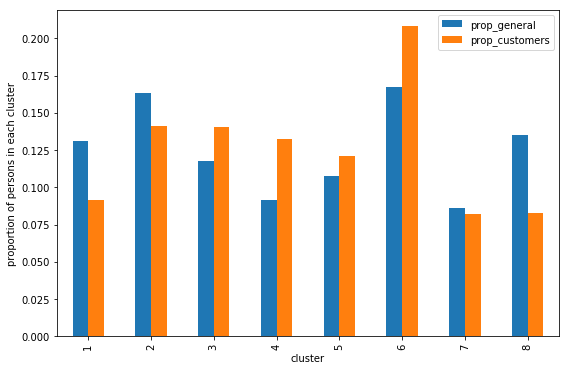

In [121]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

general_prop = []
customers_prop = []
x = [i+1 for i in range(8)] # for 8 clusters
for i in range(8):
    general_prop.append((kmeans_predict == i).sum()/len(kmeans_predict))
    customers_prop.append((kmeans_customers_predict == i).sum()/len(kmeans_customers_predict))


df_general = pd.DataFrame({'cluster' : x, 'prop_general' : general_prop, 'prop_customers':customers_prop})

#ax = sns.countplot(x='index', y = df_general['prop_1', 'prop_2'], data=df_general )
df_general.plot(x='cluster', y = ['prop_general', 'prop_customers'], kind='bar', figsize=(9,6))
plt.ylabel('proportion of persons in each cluster')
plt.show()

In [122]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
pca_link_weights(pca2, 8)

[('ANZ_HAUSHALTE_AKTIV', 0.28645223183534663),
 ('FINANZ_UNAUFFAELLIGER', 0.21671715098234218),
 ('PLZ8_ANTG1', 0.18577894285506139),
 ('FINANZ_SPARER', 0.16960176407858951),
 ('ONLINE_AFFINITAET', 0.16353963555764739),
 ('RELAT_AB', 0.16249561021647035),
 ('ORTSGR_KLS9', 0.15875281129769281),
 ('PLZ8_ANTG3', 0.14632494208029664),
 ('OST_WEST_KZ_O', 0.13453374956548381),
 ('KONSUMNAEHE', 0.13194204510662136),
 ('KBA05_ANTG2', 0.13079645955122027),
 ('ARBEIT', 0.1106792960435177),
 ('FINANZ_ANLEGER', 0.11058366969739805),
 ('KBA05_ANTG3', 0.10846330334453988),
 ('MIN_GEBAEUDEJAHR', 0.10635141451605343),
 ('PLZ8_ANTG2', 0.10100049097322336),
 ('GEBAEUDETYP_RASTER', 0.097951296113786016),
 ('BALLRAUM', 0.091709963467780209),
 ('PRAEGENDE_JUGENDJAHRE_MOVEMENT', 0.090059111038201731),
 ('GREEN_AVANTGARDE', 0.082977022838834041),
 ('MOBI_REGIO', 0.08012291934612191),
 ('SEMIO_SOZ', 0.065553694020176967),
 ('SEMIO_LUST', 0.065467003249199601),
 ('CAMEO_INTL_2015_LIFE_STG', 0.05799365083194361

In [123]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
pca_link_weights(pca2, 6)

[('KONSUMNAEHE', 0.22928742875663896),
 ('MIN_GEBAEUDEJAHR', 0.22574056908926876),
 ('SEMIO_VERT', 0.20390861288530157),
 ('BALLRAUM', 0.16641400456210714),
 ('KBA05_ANTG2', 0.089584752453466254),
 ('PRAEGENDE_JUGENDJAHRE_DECADE', 0.085611386029215156),
 ('SEMIO_ERL', 0.077075897242549832),
 ('W_KEIT_KIND_HH', 0.0749565727328593),
 ('FINANZ_UNAUFFAELLIGER', 0.071151687678353087),
 ('FINANZ_SPARER', 0.067538992664353537),
 ('ALTERSKATEGORIE_GROB', 0.061501325540945104),
 ('ANREDE_KZ', 0.060405591359010524),
 ('PLZ8_ANTG3', 0.055705332188038068),
 ('FINANZ_ANLEGER', 0.048096133896656734),
 ('KKK', 0.043877610007135553),
 ('SEMIO_DOM', 0.039423081177375703),
 ('GREEN_AVANTGARDE', 0.039421519063120525),
 ('CAMEO_INTL_2015_HOUSEHOLDS', 0.038529830411702368),
 ('ANZ_HAUSHALTE_AKTIV', 0.033531854143968469),
 ('FINANZ_HAUSBAUER', 0.033531108401612331),
 ('HEALTH_TYP', 0.030352270816241811),
 ('CAMEO_INTL_2015_LIFE_STG', 0.026462167210676627),
 ('KBA05_ANTG1', 0.022744337092250724),
 ('SEMIO_KR

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)
- By looking at the bar graph above, I am interested in **`cluster 8`** that is **overrepresented** in the customer data compared to the general population. And **`cluster 6`** that is **underrepresented** in the customer data compared to the general population.
- The Problem Statement is : To conduct Direct Marketing Campaigns towards audiences that will have the highest expected rate of returns. 
- **FOR CLUSTER 8:**
    - By looking at the above features and using Data Dictionary for reference, `Estimated household net income`('HH_EINKOMMEN_SCORE'), `Number of professional academic title holders in household`('ANZ_TITEL') are the two major features in the customer data that are relatively unpopular with the mail-order company.
    - `Online affinity`('ONLINE_AFFINITAET'), `Size of community`('ORTSGR_KLS9') are two of the features which are popular rather they do matter for some analytical use to the mail-order company since these features will help the company to target a large amount of audience.
- **FOR CLUSTER 6:**
    - By looking at the above features and using Data Dictionary for reference, `People with event-oriented Personality typology`('SEMIO_ERL') and `People with Dreamful personality typology`('SEMIO_VERT') are the relatively popular features with the company since these are the people who would engage more in the reading and reverting back to the mails / other campaigns and remain active with the company.
    - Whereas, `Dominating movement of person's youth (avantgarde vs. mainstream` ('PRAEGENDE_JUGENDJAHRE_MOVEMENT') and `People with Rational Personality typology`('SEMIO_RAT') are the unpopular features with the mail_order company.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.